In [18]:
import numpy as np
import matplotlib.pyplot as plt
import time
from subprocess import Popen, PIPE

def surge_exp(E,p,lmbd,E_th):
    x=E-E_th
    return np.heaviside(x,1)*((e/lmbd)**p)*(x**p)*np.exp(-p*x/lmbd)
    
def surge_pwr(E,p,lmbd,E_th):
    x=E-E_th
    return np.heaviside(x,1)*(lmbd**p)*(p+1)**(p+1)*x/(x+p*lmbd)**(p+1)
    
    
def Input(Y,m):
    A=Y[:m]
    p=Y[m:2*m]
    lmbd=Y[2*m:3*m]
    E_th=Y[3*m:]
    
    n=500
    E=np.logspace(-1,3,n)
    
    sigma_m=0
    for i in range(m):
        sigma_m+=A[i]*1e-20*surge_pwr(E,p[i],lmbd[i],E_th[i])
    
    f=open("LXCat0.txt","w")
    f.write('----------------------\n')
    f.write('ELASTIC\nSurge\n')
    f.write('1.371541e-4 / mass ratio\n')
    f.write('----------------------\n')
    
    for i in range(n):
        f.write(str(E[i])+' '+str(sigma_m[i])+'\n')

    '''
    f.write('----------------------\n')
    f.write('EXCITATION\nSurge\n')
    f.write(str(E_th)+' / Thresold Energy\n')
    f.write('1.371541e-4 / mass ratio\n')
    f.write('----------------------\n')
    sigma_exc=slope*(E-E_th)*np.heaviside(E-E_th,1)
    for i in range(n):
        f.write(str(E[i])+' '+str(sigma_exc[i])+'\n')
    '''

    plt.loglog(E,(sigma_m)*1e20)
    plt.show()
    
    f.close()
    
def ex(grid=100,E_min=1e-3,E_max=1e3,n=1000):
        f=open("ex.dat","w")
        f.write("READCOLLISIONS\n")
        f.write("LXCat0.txt\nSurge\n1\n")
        f.write("CONDITIONS\n")
        f.write("1       / Electric field / N (Td)\n")
        f.write("0        / Angular field frequency / N (m3/s)\n")
        f.write("0.        / Cosine of E-B field angle\n")
        f.write("0.       / Gas temperature (K)\n")
        f.write("300.      / Excitation temperature (K)\n")
        f.write("0.        / Transition energy (eV)\n")
        f.write("0.        / Ionization degree\n")
        f.write("1e-6      / Plasma density (1/m3)\n")
        f.write("1.        / Ion charge parameter\n")
        f.write("1.        / Ion/neutral mass ratio\n")
        f.write("1         / e-e momentum effects: 0=No; 1=Yes*\n")
        f.write("1         / Energy sharing: 1=Equal*; 2=One takes all\n")
        f.write("1         / Growth: 1=Temporal*; 2=Spatial; 3=Not included; 4=Grad-n expansion\n")
        f.write("0.        / Maxwellian mean energy (eV) \n")
        f.write(str(grid)+"      / # of grid points\n")
        f.write("0         / Manual grid: 0=No; 1=Linear; 2=Parabolic \n")
        f.write("1000.      / Manual maximum energy (eV)\n")
        f.write("1e-10     / Precision\n")
        f.write("1e-5      / Convergence\n")
        f.write("1000      / Maximum # of iterations\n")
        f.write("1        / Gas composition fractions\n")
        f.write("1         / Normalize composition to unity: 0=No; 1=Yes\n")
        f.write("RUNSERIES\n")
        f.write("1          / Variable: 1=E/N; 2=Mean energy; 3=Maxwellian energy \n")
        f.write(str(E_min)+" "+str(E_max)+"  / Min Max\n")
        f.write(str(n)+"         / Number \n")
        f.write("3          / Type: 1=Linear; 2=Quadratic; 3=Exponential\n")
        f.write("SAVERESULTS\n")
        f.write("Surge.dat        / File \n")
        f.write("3        / Format: 1=Run by run; 2=Combined; 3=E/N; 4=Energy; 5=SIGLO; 6=PLASIMO\n")
        f.write("1        / Conditions: 0=No; 1=Yes\n")
        f.write("1        / Transport coefficients: 0=No; 1=Yes\n")
        f.write("1        / Rate coefficients: 0=No; 1=Yes\n")
        f.write("0        / Reverse rate coefficients: 0=No; 1=Yes\n")
        f.write("0        / Energy loss coefficients: 0=No; 1=Yes\n")
        f.write("1        / Distribution function: 0=No; 1=Yes \n")
        f.write("0        / Skip failed runs: 0=No; 1=Yes\n")
        f.write("END")
        f.close()
        
def Bolsig():
    t=time.time()
    process = Popen(['./bolsigminus', 'ex.dat'], stdout=PIPE, stderr=PIPE)
    stdout, stderr = process.communicate()
    #print (stdout)
    
def Output(n=1000):
    f=open("Surge.dat","r")
    
    E=np.zeros(n)
    out=np.zeros((n,3))
    for line in f:
        if line[:8]=='E/N (Td)' and line[8:].strip()=='Mean energy (eV)':
            for i in range(n):
                l=f.readline().strip()
                if len(l)==0: break
                E[i], out[i,0] = [float(x) for x in l.split()]
        if line[:8]=='E/N (Td)' and line[8:].strip()=='Mobility *N (1/m/V/s)':
            for i in range(n):
                l=f.readline().strip()
                if len(l)==0: break
                E[i], out[i,1] = [float(x) for x in l.split()]
        if line[:8]=='E/N (Td)' and line[8:].strip()=='Diffusion coefficient *N (1/m/s)':
            for i in range(n):
                l=f.readline().strip()
                if len(l)==0: break
                E[i], out[i,2] = [float(x) for x in l.split()]

    out[:,1]=out[:,1]*E*1e-21 #Drift Velocity
    out[:,2]=out[:,2]*1e-24 #Diffusion coefficient
    
    plt.loglog(E,out[:,0])
    plt.loglog(E,out[:,1])
    plt.loglog(E,out[:,2])
    plt.show()
    
    #print('time:',time.time()-t)
    return np.log10(out)


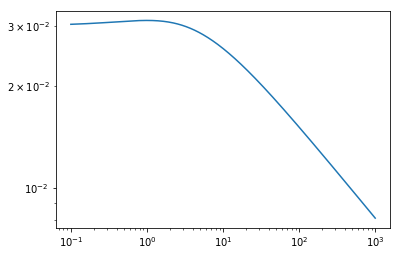

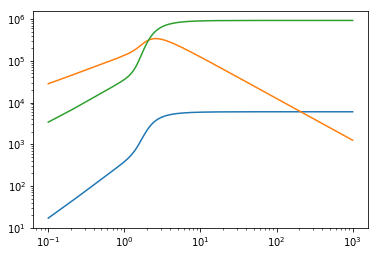

[0.03117084] [0.27348101] [2.38098757] [-1.38208823] 0 

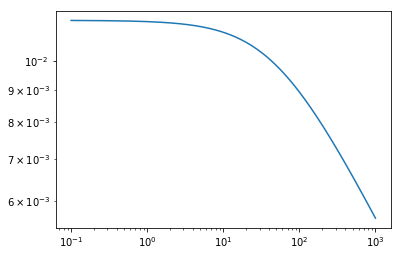

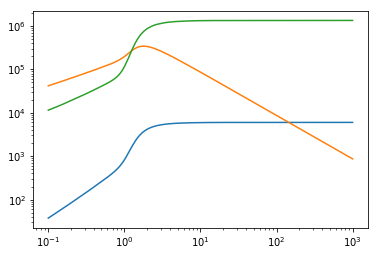

[0.02170723] [0.23547791] [1.12864085] [-47.83922545] 1 

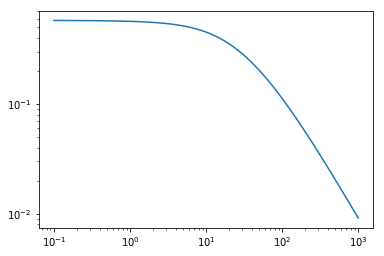

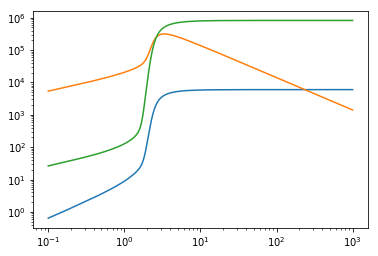

[0.60250492] [1.20552655] [7.4787639] [-10.90714885] 2 

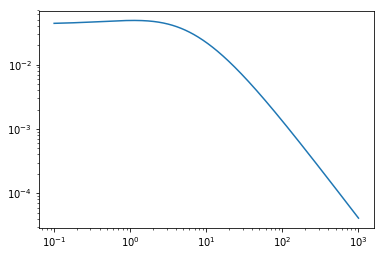

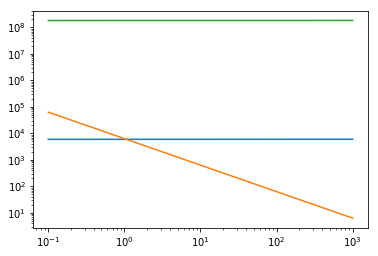

[0.04844683] [1.5484272] [2.24085079] [-1.12985122] 3 

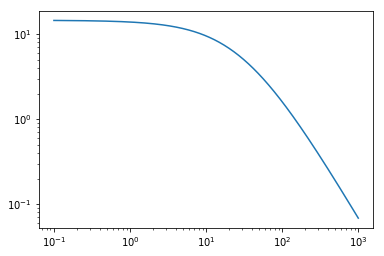

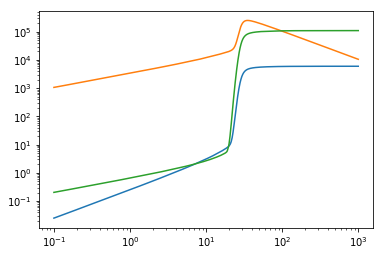

[39.65177565] [1.52228917] [3.40353793] [-21.18196011] 4 

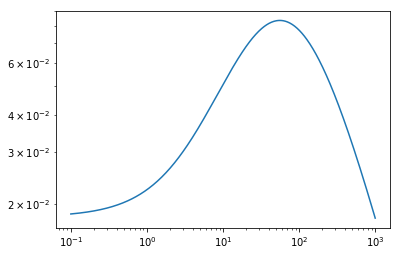

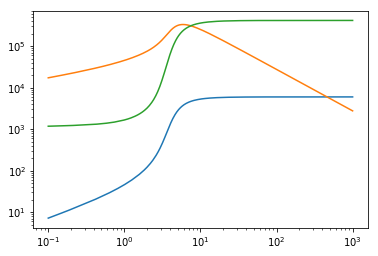

[0.08361133] [0.9878456] [59.4124957] [-3.60094927] 5 

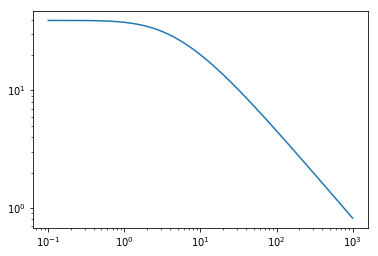

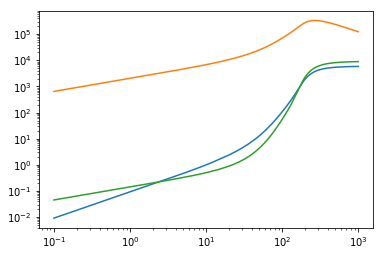

[39.45608773] [0.75536853] [1.60624388] [-1.44127489] 6 

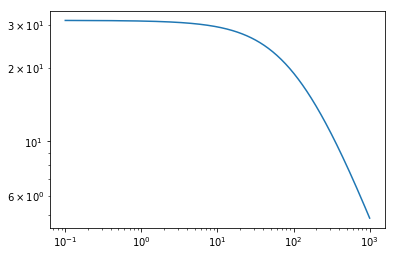

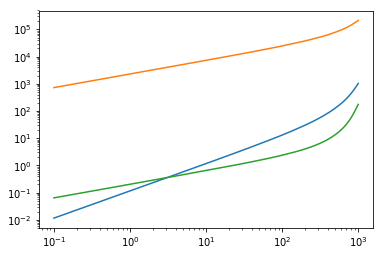

[39.26723695] [0.82402493] [23.13795133] [-65.03026634] 7 

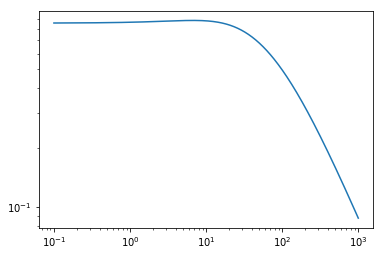

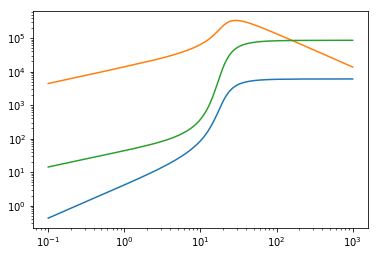

[0.88328809] [0.92119844] [22.24066439] [-15.52545387] 8 

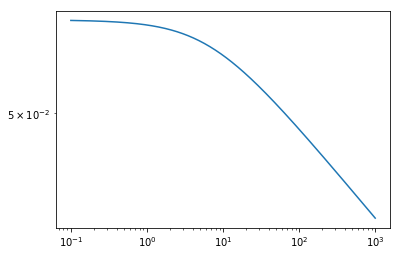

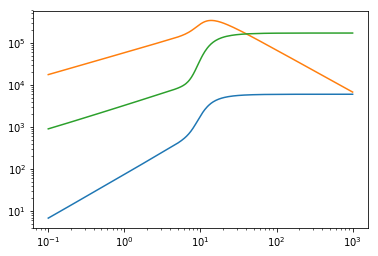

[0.05707337] [0.04936699] [1.75420717] [-4.42158401] 9 24.61238193511963


In [19]:
cross=open('Y.csv','wb')
trans=open('X.csv','wb')

n=10
m=1 #no. of Surge functions

A=10**(np.random.rand(n,m)*4-2) # in range (0.01 to 100) (Angstrom)^2
p=np.random.rand(n,m)*2  #in (0 to 2) 
lmbd=10**(np.random.rand(n,m)*2) #in (1 to 100) (eV)
E_th=-10**(np.random.rand(n,m)*2) # in (-1 to -100) (eV)
Y=np.zeros((n,4*m))
Y[:,:m]=A
Y[:,m:2*m]=p
Y[:,2*m:3*m]=lmbd
Y[:,3*m:]=E_th

t=time.time()
np.savetxt(cross,Y,delimiter=',')
for i in range(n):
    Input(Y[i,:],m)
    ex(grid=100,E_min=0.1,E_max=1e3,n=1000) #n cannot be more than 1000
    Bolsig()
    X=Output(n=1000)
    np.savetxt(trans,np.reshape(X,(1,-1)),delimiter=',')
    print(Y[i,:m],Y[i,m:2*m],Y[i,2*m:3*m],Y[i,3*m:],i,end=' ')
print(time.time()-t)
cross.close()
trans.close()